#### Bibliotecas

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf

#### Importando e realizando as primeiras visualizações do Dataframe

In [105]:
# Trazendo os dados da base
df_ibov = pd.read_csv("/content/drive/MyDrive/5. FIAP/Tech Challenge/Fase 2 /Dados Históricos - Ibovespa.csv",sep=",")

In [106]:
# Visualizando o Dataframe
df_ibov.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,11.03.2025,123.507,124.519,124.625,122.636,"8,81B","-0,81%"
1,10.03.2025,124.519,125.031,125.031,123.471,"9,37B","-0,41%"
2,07.03.2025,125.035,123.357,125.822,122.530,"9,98B","1,36%"
3,06.03.2025,123.358,123.048,124.112,122.681,"10,06B","0,25%"
4,05.03.2025,123.047,122.799,123.364,122.747,"9,60B","0,20%"


In [107]:
# Verificando o tamanho do meu DataFrame
df_ibov.shape

(5000, 7)

In [108]:
# Verificando informações do meu DataFrame
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [109]:
# Verificando valores nulos no Dataframe

df_ibov.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


In [110]:
# Verificando valor nulo na coluna 'Vol.'

df_ibov[df_ibov["Vol."].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2255,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


#### Realizando tratamento de dados

In [111]:
# Convertendo a coluna data de object para datetime

df_ibov['Data'] = pd.to_datetime(df_ibov['Data'], format='%d.%m.%Y')

In [112]:
# Função para converter a coluna Volume de string para float

def converter_valor(valor):
    if pd.isna(valor):
        return None
    valor = valor.replace(',', '.').strip()
    if valor.endswith('B'):
        return float(valor[:-1]) * 1_000_000_000
    elif valor.endswith('M'):
        return float(valor[:-1]) * 1_000_000
    elif valor.endswith('K'):
        return float(valor[:-1]) * 1_000
    else:
        return float(valor)

In [113]:
# Apicando a coluna convertida no df
df_ibov['Vol.'] = df_ibov['Vol.'].apply(converter_valor)

In [114]:
# Filtrando apenas fevereiro de 2016 com valores não nulos
feb_2016 = df_ibov[(df_ibov['Data'].dt.month == 2) & (df_ibov['Data'].dt.year == 2016)]

# Criando média referente o mês de fevereiro/2016
media_fev = feb_2016['Vol.'].mean()

In [115]:
# Apicando a média no valor nulo

df_ibov.loc[(df_ibov['Data'] == '2016-02-10') & (df_ibov['Vol.'].isnull()), 'Vol.'] = media_fev

Para ajustar o valor nulo da coluna 'Vol' realizei a média do 02/2016 , pois o volume financeiro é altamente sensível a eventos de curto prazo (crises, decisões políticas, etc).

In [116]:
df_ibov.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [117]:
# Renomenando minhas colunas Data e Último

df_ibov.rename(columns={'Data': 'dt', 'Último': 'Y'}, inplace=True)

In [118]:
# Transformando minha coluna data em index e dropando a coluna excedente

df_ibov.index = df_ibov.dt

df_ibov.drop('dt',inplace=True,axis=1)

df_ibov.head()

,Y,Abertura,Máxima,Mínima,Vol.,Var%
dt,,,,,,
2025-03-11,123.507,124.519,124.625,122.636,8.810000e+09,"-0,81%"
2025-03-10,124.519,125.031,125.031,123.471,9.370000e+09,"-0,41%"
2025-03-07,125.035,123.357,125.822,122.530,9.980000e+09,"1,36%"
2025-03-06,123.358,123.048,124.112,122.681,1.006000e+10,"0,25%"
2025-03-05,123.047,122.799,123.364,122.747,9.600000e+09,"0,20%"


#### Escolhendo e plotando meus dados para análise

In [119]:
df_ibov_2 = df_ibov['Y']

df_ibov_2.head()

,Y
dt,
2025-03-11,123.507
2025-03-10,124.519
2025-03-07,125.035
2025-03-06,123.358
2025-03-05,123.047


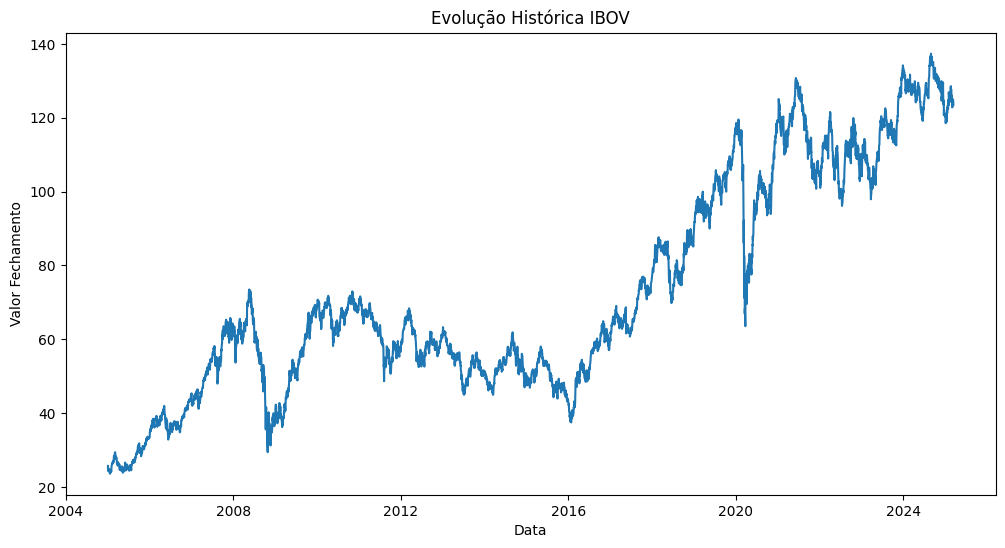

In [123]:
plt.figure(figsize=(12,6))
plt.plot(df_ibov_2)
plt.xlabel('Data')
plt.ylabel('Valor Fechamento')
plt.title('Evolução Histórica IBOV')

plt.show()

In [125]:
# Decompondo meus valores de série temporal -  Utilizei o periodo de 252 dias pois é o número médio de dias úteis em um ano de pregão (descontando fins de semana e feriados)

resultados_ibov = seasonal_decompose(df_ibov_2,period=252)

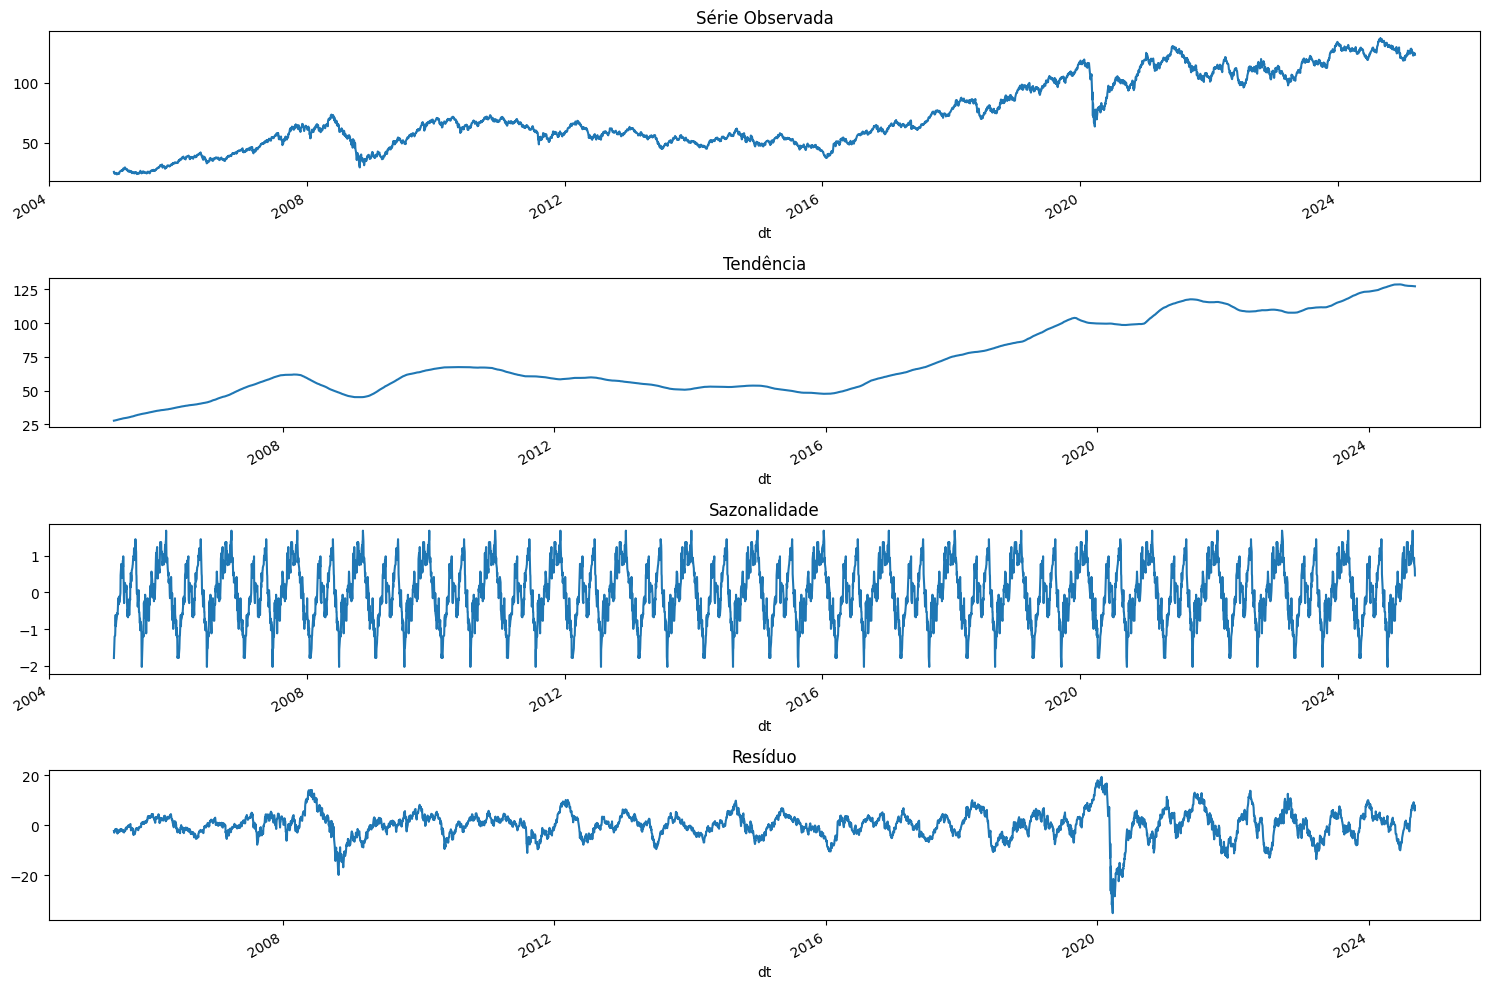

In [147]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))

resultados_ibov.observed.plot(ax=ax1)
ax1.set_title("Série Observada")

resultados_ibov.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados_ibov.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados_ibov.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()

In [151]:
#ADF - Teste de Estacionariedade — Dickey-Fuller

x_ibov = df_ibov_2.values

result_ibov = adfuller(x_ibov)

print("Teste ADF")
print(f"Teste Estatístico : {result_ibov[0]}")
print(f"P - Value : {result_ibov[1]}")
print("Valores Criticos:")

for key,value in result_ibov[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -1.6076819838374903
P - Value : 0.47973354177400257
Valores Criticos:
	1%:-3.43166168173001
	5%:-2.8621196211801374
	10%:-2.5670785331097763


Com essa primeira análise conseguimos verificar que minha série temporal não é estacionária necessitando tratamento como função logarítmica e/ou diferenciação

<Figure size 1000x600 with 0 Axes>

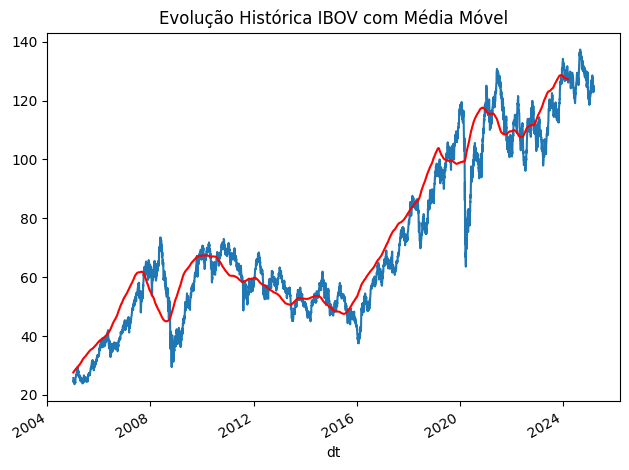

In [157]:
# Verificando minha média móvel

ma_ibov = df_ibov_2.rolling(252).mean()

plt.figure(figsize=(10,6))
f,ax = plt.subplots()
df_ibov_2.plot(ax=ax, legend= False)
ma_ibov.plot(ax=ax, legend= False,color='r')



plt.title('Evolução Histórica IBOV com Média Móvel')

plt.tight_layout()
plt.show()